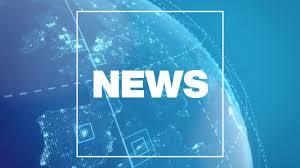

In recent years, the spread of fake news—misleading or false information presented as news—has become a growing concern, especially with the rise of social media platforms. Fake news can manipulate public opinion, influence political decisions, and cause widespread misinformation. Detecting and classifying news articles as real or fake is a crucial task in the field of Natural Language Processing (NLP) and Machine Learning (ML).

This project focuses on building a machine learning model to automatically detect whether a news article is real or fake based on its textual content.


This dataset is structured in two CSV files: one containing real news (True.csv) and one containing fake news (Fake.csv). It includes:

Title: The article’s headline

Text: The main body content

Subject: The article’s topic category (e.g., politics, world news)

Date: Publication date

Label: Implicit via file origin (True vs Fake) 

Together, they compile roughly 21,417 real news and 23,502 fake news articles—a total of ~44,919 entries

The main problem tackled in this project is:

How can we accurately classify a news article as fake or real using machine learning techniques applied to its textual data?

Key challenges include:

Dealing with unstructured data: Text data must be preprocessed and transformed into a format suitable for machine learning models.

Feature extraction: Identifying the most relevant features in the text (using methods like TF-IDF, Bag-of-Words, or word embeddings).

Model selection: Choosing effective classification algorithms (e.g., Logistic Regression, Naive Bayes, Random Forests, or deep learning models).

Avoiding overfitting: Ensuring the model generalizes well to unseen articles.

Handling bias in language: Making sure the model is not overly influenced by style or topic rather than content veracity.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fakedf=pd.read_csv('Fake.csv')
fakedf['isReal']=0
truedf=pd.read_csv('True.csv')
truedf['isReal']=1
print(fakedf.columns)
print(truedf.columns)
detectdf=pd.concat([fakedf,truedf],axis=0)
detectdf=detectdf.sample(frac=1,random_state=1808).reset_index().drop('index',axis=1)
detectdf.isnull().sum()

Index(['title', 'text', 'subject', 'date', 'isReal'], dtype='object')
Index(['title', 'text', 'subject', 'date', 'isReal'], dtype='object')


title      0
text       0
subject    0
date       0
isReal     0
dtype: int64

In [118]:

month_map = {
    "Jan": "January",
    "Feb": "February",
    "Mar": "March",
    "Apr": "April",
    "May": "May",
    "Jun": "June",
    "Jul": "July",
    "Aug": "August",
    "Sep": "September",
    "Oct": "October",
    "Nov": "November",
    "Dec": "December"
}
pattern = r'\b(' + '|'.join(month_map.keys()) + r')\b'
for key,values in month_map.items():
    
    detectdf['date']=detectdf['date'].str.replace(pattern,values,regex=True)


print(detectdf['date'].head())
detectdf['date'] = detectdf['date'].str.strip()
detectdf['date'] = pd.to_datetime(detectdf['date'], format="%B %d, %Y", errors='coerce')
detectdf=detectdf.dropna(subset=['date'])

0       August 24, 2017 
1      January 25, 2017 
2       January 20, 2016
3       December 1, 2016
4    September 29, 2017 
Name: date, dtype: object


### Our Data is fully loaded and shuffeled 


# Text processing 

<div >
	<b>🚦 Time to Split!</b><br>
	<br>
	Before building our machine learning model, we need to <b>split our dataset</b> into training and testing sets.<br>
	This ensures our model learns from one part of the data and is evaluated on unseen data for a fair assessment.<br>
	<br>
	<i>Let's get ready to divide and conquer! 🧩</i>
</div>

In [119]:
from sklearn.model_selection import train_test_split
def containnum(x):
    for c in x:
        if(c.isdigit()):
            return 1
    return 0

dicti={'com':detectdf['title']+detectdf['text']+detectdf['subject'],
'year':detectdf['date'].dt.year,
'day':detectdf['date'].dt.day,
'month':detectdf['date'].dt.month,
'isReal':detectdf['isReal'],
'titleLength':detectdf['title'].apply(lambda x:len(x)),
'has_num':detectdf['text'].apply(containnum)}
sample=pd.DataFrame(dicti)
sample=sample.dropna()
y=detectdf['isReal']
x_train,x_test,x_extra_train,x_extra_test,y_train,y_test=train_test_split(sample['com'],sample[['year','day','month','titleLength','has_num']],y,random_state=2,test_size=0.3,stratify=y)
sample.isna().sum()

com            0
year           0
day            0
month          0
isReal         0
titleLength    0
has_num        0
dtype: int64

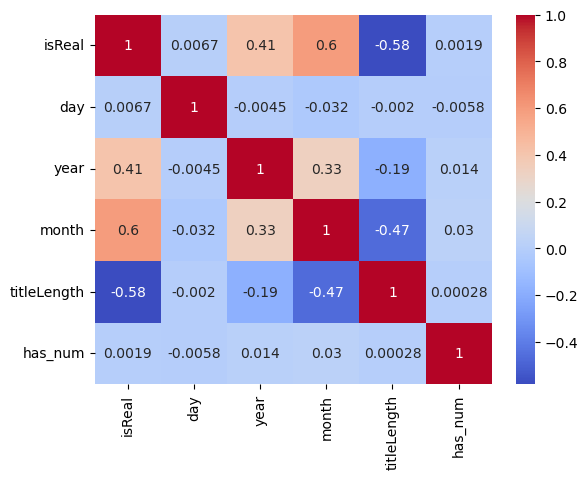

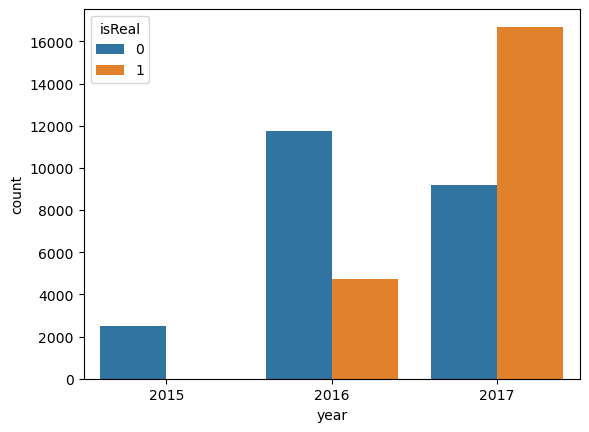

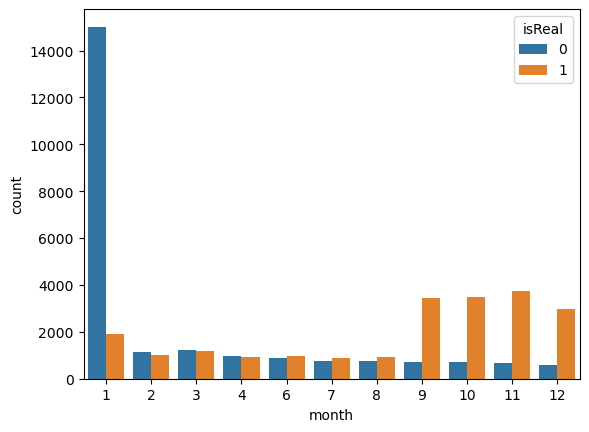

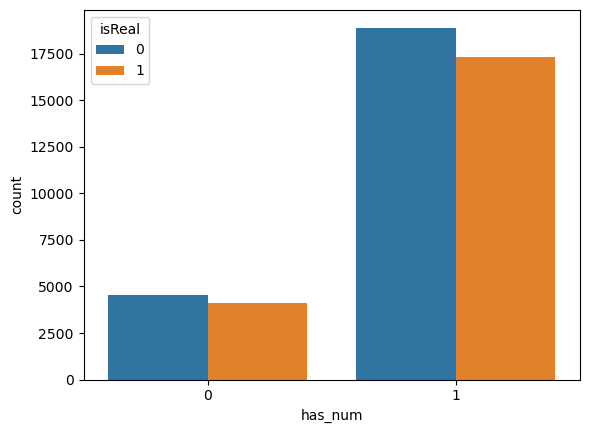

<Axes: xlabel='titleLength', ylabel='Count'>

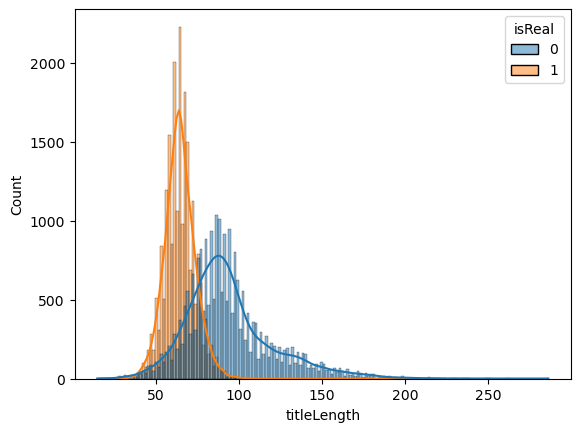

In [127]:

sns.heatmap(sample[['isReal','day','year','month','titleLength','has_num']].corr(),annot=True,cmap='coolwarm')
plt.show()
def show(col):
    sns.countplot(sample,x=col,hue='isReal')
    plt.show()
show('year')
show('month')
show('has_num')
sns.histplot(kde=True,data=sample,x='titleLength',hue='isReal')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
vectorizer=TfidfVectorizer(stop_words='english')
rf=RandomForestClassifier(random_state=2)
pipeline=Pipeline(
    [('tfidf',vectorizer)
    ,('rf',rf)]
)
params={
    'tfidf__max_df': [0.7, 0.85, 1.0],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators':[100,300,500,1000],
    'rf__max_depth':[None,10,30,50],
    'rf__min_samples_split':[2,5,10,20],
    'rf__min_samples_leaf':[1, 2, 4, 10],
    'rf__max_features':['sqrt','log2']
}
rfcv=GridSearchCV(pipeline,params,cv=5,scoring='roc_auc',n_jobs=-1)
rfcv.fit(x_train,y_train)
print(rfcv.best_score_)

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
x_train_combined=pd.DataFrame({
    'text':x_train,
    'year':x_extra_train['year'],
    'month':x_extra_train['month'],
    'day':x_extra_train['day'],
    'title_length':x_extra_train['titleLength'],
    'hasNum':x_extra_train['has_num']
})
x_test_combined=pd.DataFrame({
    'text':x_test,
    'year':x_extra_test['year'],
    'month':x_extra_test['month'],
    'day':x_extra_test['day'],
    'title_length':x_extra_test['titleLength'],
    'hasNum':x_extra_test['has_num']
})
print(x_train_combined.isnull().sum())
preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(stop_words='english',max_df=0.85,min_df=3), 'text'),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['month', 'day']),
    ('extra', 'passthrough', ['title_length', 'hasNum','year'])
])
rfa=GradientBoostingClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,max_features='log2')

pipeline=Pipeline([('preprocess',preprocessor),('gbc',rfa)])
pipeline.fit(x_train_combined,y_train)
y_pred=pipeline.predict_proba(x_test_combined)[:,1]
print(metrics.roc_auc_score(y_test,y_pred))


text            0
year            0
month           0
day             0
title_length    0
hasNum          0
dtype: int64
0.9956858979715733


In [122]:
print(metrics.classification_report(y_test,np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7031
           1       0.98      0.96      0.97      6425

    accuracy                           0.97     13456
   macro avg       0.97      0.97      0.97     13456
weighted avg       0.97      0.97      0.97     13456

